<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Conjugacy, Beta-Binomial Model, Maximum Likelihood

_Authors: Kiefer Katovich (SF), Riley Dallas (Austin)_ 

---

### Learning Objectives
- Understand the Beta Distribution
- Describe the concept of "conjugacy" and "conjugate priors" in Bayesian statistics
- Set up an example of the Beta-Binomial model using election data
- Calculate the Maximum Likelihood Estimate
- Use the Beta-Binomial model to build our example in a Bayesian framework

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 2020 Democratic Party presidential primaries
---

For today's lecture, we're going to focus on the 2020 presidential race. It's custom for the incumbent (Trump) to run unopposed for their party, so we'll target the pool of Democratic challengers. Here are the current front runners:

- Joe Biden
- Bernie Sanders
- Kamala Harris
- Beto O'Rourke
- Elizabeth Warren
- Cory Booker
- Pete Buttigieg

In keeping with the spirit of Bayes, we need to create a prior that represents our beliefs about the outcome of this primary. From there, we'll gather some recent polling results from [FiveThirtyEight](https://projects.fivethirtyeight.com/2020-primaries/democratic/national/) and use that data to update our beliefs as a posterior distribution.

## Who should we represent?
---

Let's imagine we're a consultancy, and all the candidates are interested in our services (because we're awesome, of course). Ethics dictate that we only choose one candidate to represent, so we'll vote on who we'll work for:

Cast your vote in the **anonymous** Slack poll:

> /poll "Who should we work for?" "Joe Biden" "Bernie Sanders" "Kamala Harris" "Beto O'Rourke" "Elizabeth Warren" "Cory Booker" "Pete Buttigieg" anonymous limit 1

## Our objective: understand the posterior distribution
---

$p$ is the parameter we're trying to learn more about: the proportion of votes our candidate will get. 

To get a posterior for $p$, we'll do the following:
1. Establish a **prior** belief about $p$ as a distribution: $f(p)$
2. Use recent polling data to create our Binomial likelihood: $f(n,k|p)$
    - `n` is the total survey responses
    - and `k` is the number of responses in favor of our candidate
3. Use that data to update our belief about $p$ as a posterior distribution: $f(p|n,k)$

Mathematically, our objective can be summarized using a variant of Bayes' rule:

### $$f(p|n,k) \propto f(n,k|p) * f(p)$$

## Our prior and posterior beliefs must be distributions
---

In Bayesian statistics, we interested in both $p$ **and the uncertainty that surrounds $p$.** Therefore, the prior and posterior will both be distributions, where:
- the X-axis is infinite number of percentages between 0 and 1
- and the Y-axis represents our **confidence** in each of those percentages.

## Step 1: Establish our prior
---

The first step in Bayesian inference is to create a prior distribution that represents our belief about $p$. Remember, $p$ represents the percentage of votes our candidate is likely to win in the primaries. 

## The Beta distribution
---

The Beta distribution works perfectly for our prior because it **represents _a distribution of probabilities_**. 

The beta distribution is parameterized by two values, $\alpha$ and $\beta$.

###  $ Beta(\alpha, \beta) =
\begin{cases}
\alpha &= \text{number of successes + 1} \\
\beta &= \text{number of failures + 1}
\end{cases} $

The mean of the Beta distribution is defined as:

### $\mu = \dfrac{\alpha}{\alpha + \beta}$


## Uninformed prior
---

We'll take the naive approach and start with an *uninformed prior*. That is, we assume each value for $p$ is equally likely. To create a uniform Beta distribution, we'll use the following parameters:

```python
alpha_prior = 1
beta_prior = 1
```

In [2]:
# Create our uninformed prior
alpha_prior = 1
beta_prior = 1
prior_distn = stats.beta(alpha_prior, beta_prior)

In [3]:
# Mean of the prior dist'n
prior_distn.mean()

0.5

In [4]:
# Std of the prior dist'n
prior_distn.std()

0.28867513459481287

## Plot the beta prior
---

In the cell below, let's plot our beta distribution. Use `numpy.linspace` to create a list of probabilities for plotting the x axis.

In [5]:
# Create list of percentages for plotting x-axes
percentages_for_plotting_x_axes = np.linspace(0, 1, 1001)

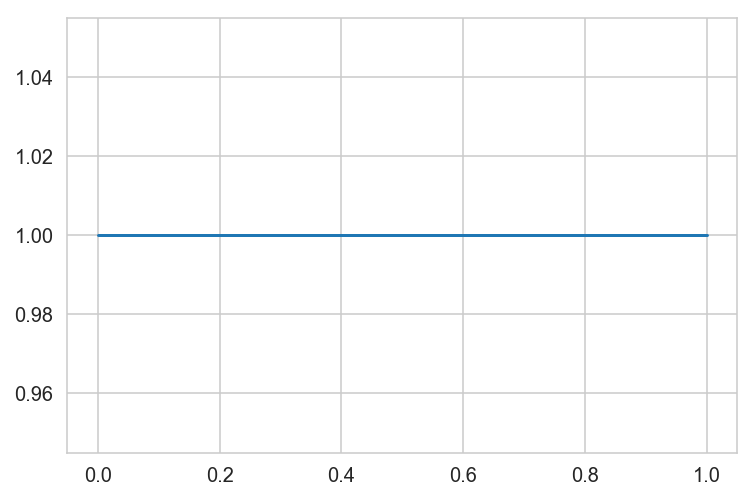

In [6]:
# Plot prior dist'n using percentages from previous cell
plt.plot(percentages_for_plotting_x_axes, prior_distn.pdf(percentages_for_plotting_x_axes))

## Step 2: Establish our likelihood function
---

Now we need to update our beliefs with some data. [FiveThirtyEight](https://projects.fivethirtyeight.com/2020-primaries/democratic/national) is an excellent resource for political polling information. 

Let's use the results from the 5 most recent polls for our likelihood:

<div style="float: left">

| Dates              | Pollster           | Sample Size | Biden | Sanders | Warren | Harris | Buttigieg | O'Rourke | Booker |
|--------------------|--------------------|-------------|-------|---------|--------|--------|-----------|----------|--------|
| JUL 31-AUG 2, 2019 | HarrisX            | 914         | 256   | 146     | 73     | 73     | 27        | 27       | 27     |
| AUG 1, 2019        | Morning Consult    | 2,419       | 774   | 435     | 363    | 242    | 145       | 73       | 73     |
| JUL 31-AUG 1, 2019 | Harris Interactive | 585         | 199   | 99      | 47     | 53     | 23        | 18       | 12     |
| JUL 30-AUG 1, 2019 | HarrisX            | 896         | 269   | 161     | 81     | 72     | 36        | 27       | 27     |
| JUL 31, 2019       | Morning Consult    | 2,410       | 819   | 458     | 337    | 241    | 145       | 48       | 72     |

</div>

This gives us the following totals:

```python
biden = 2317
sanders = 1299
warren = 901
harris = 681
buttigieg = 376
orourke = 193
booker = 211

n_surveys = 7224
```

In [7]:
buttigieg = 376
n_surveys = 7224

<a id='pmf'></a>
## Review: the Binomial distribution probability mass function
---

Recall that the number of "success" trials in $n$ trials is modeled with the Binomial distribution. The binomial distribution has the probability mass function:

### $$ P(k, n \;|\; p) = \binom{n}{k} p^k (1 - p)^{(n-k)} $$

Where $k$ is the number of successes,

$n$ is the number of total trials,

and $p$ is the probability of success for each trial.

**We can calculate the probability mass function for a given $n$ and $p$:**

In [8]:
# Coin flips
p_heads = .25
n_flips = 50
coin_distn = stats.binom(n_flips, p_heads)
coin_distn.pmf(25)

8.449194669903904e-05

In [9]:
# Siblings
p_daughter = .5
n_kids = 6
daughter_distn = stats.binom(n_kids, p_daughter)
daughter_distn.pmf(1)

0.09375000000000003

In [10]:
# Polling numbers, likelihood fn
def likelihood_fn(p, n, k):
    distn = stats.binom(n, p)
    return distn.pmf(k)

In [11]:
likelihood_fn(p=.2, n=n_surveys, k=buttigieg)

2.9614818149394135e-287

<a id='likelihood'></a>
## The Binomial likelihood
---

The likelihood represents the probability of observing $k$ successes out of $n$ trials _given a probability of success $p$._

This $p$ can be fixed, say at $p = 0.3$, in which case we would evaluate the likelihood at exactly that point. We could also represent $p$ as a distribution over the range of possible $p$ values. Evaluating the likelihood at all of our different "hypotheses" about what $p$ could be. 

In [12]:
# Plot binom likelihood for our data
likelihoods = [likelihood_fn(p=p, n=n_surveys, k=buttigieg) for p in percentages_for_plotting_x_axes]

(0, 0.1)

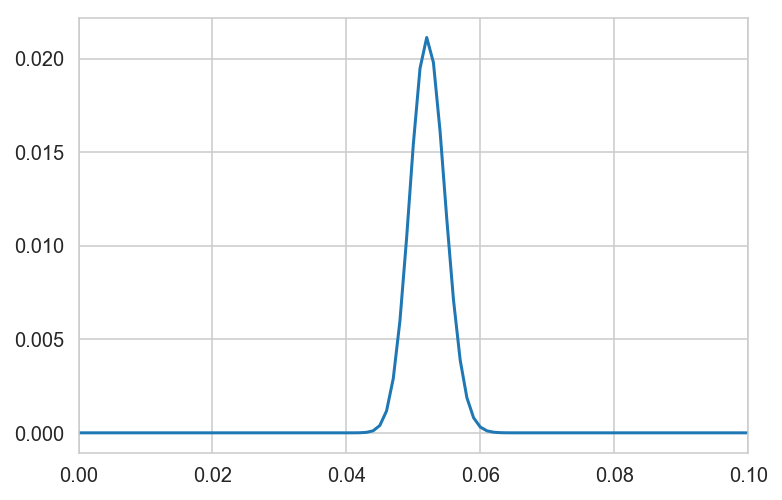

In [13]:
plt.plot(percentages_for_plotting_x_axes, likelihoods)
plt.xlim([0, .1])

<a id='mle'></a>
## The "Maximum Likelihood Estimate" for $p$
---

If we were to _just_ focus on the likelihood part of Bayes Theorem, we could ask "what is the value of the parameter $p$ that maximizes the value of the likelihood function?" This is precisely what we do in Frequentist statistics to find our point estimate of a parameter. 

Remember that Frequentists have no interest in the prior or posterior beliefs about the probability of the parameter's value. Frequentists state that there is no probability associated with a parameter. 

Because we only take a sample of people, we may by chance measure a percentage of votes for our candidate that deviates from that true probability to some degree. Remember: in Frequentist statistics, it is the data that has a probability rather than the parameter!

**For the Binomial distribution, we can easily calculate the value for $p$ that makes our observed data the most likely: it is going to be the fraction of survey responses in favor of our candidate, divided by the total responses.**

In [14]:
# mle
buttigieg / n_surveys

0.05204872646733112

<a id='beta-conjugate'></a>
## Putting it all together: the Beta as a "conjugate prior" to the Binomial likelihood
---

Let's recap what we've done up to this point:
1. We're trying to understand $p$: The proportion of votes our candidate will win
2. We created a beta distribution $f(p)$ to represent our prior beliefs about $p$
3. We've gathered survey data, and calculated the value for $p$ that maximizes the likelihood of the surveys we've observed.

Like our prior, our posterior distribution $f(p|n,k)$ will be a beta distribution as well. Because our likelihood function is binomial, creating the parameters $\alpha_{posterior}$ and $\beta_{posterior}$ for our beta distribution is a matter of simple addition:

### $$ \begin{aligned}
\alpha_{posterior} &= k + \alpha_{prior} \\
\beta_{posterior} &= n - k + \beta_{prior}
\end{aligned} $$


In [15]:
# Create alpha and beta posteriors
alpha_posterior = alpha_prior + buttigieg
beta_posterior = n_surveys - buttigieg + beta_prior 
posterior_distn = stats.beta(alpha_posterior, beta_posterior)

## Conjugacy
---

Our prior and likelihood play nicely together because of one word: conjugacy. **Conjugacy** and "conjugate priors" are important concepts in Bayesian statistics. 

> The essential idea is that the *posterior* distribution is guaranteed to have the same mathematical form as the *prior* distribution when the prior distribution is a conjugate prior to the likelihood function.

There are [many conjugate priors and posteriors](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions). They are extremely useful because they make the prior-posterior update algebraically solvable. When there is no conjugate prior, sampling techniques such as Markov Chain Monte Carlo are often necessary.

This lecture covers the most classic conjugate prior scenario: the Beta-Binomial model. Binomial models are appropriate for binary events. The prior distribution on the probability of a binary event is a Beta distribution. As it turns out, the Beta distribution is conjugate to the Binomial likelihood and we are guaranteed to get out a posterior distribution that is also a Beta distribution.

(0, 0.1)

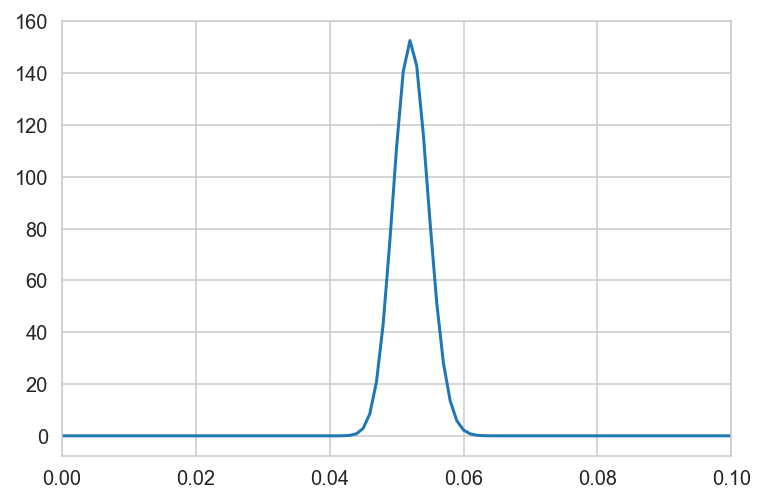

In [16]:
# Plot posterior distribution
plt.plot(percentages_for_plotting_x_axes, posterior_distn.pdf(percentages_for_plotting_x_axes))
plt.xlim([0, .1])

## Maximum A Posteriori (MAP): Mode of Posterior Distribution
---

Once we have $\alpha_{posterior}$ and $\beta_{posterior}$ for the Beta distribution, we have completely characterized the probability of the conversion rate.

The MAP (i.e., mode of the posterior distribution) can be calculated quite easily if the mathematical form of the distribution is known.  For Beta it is

### $$MAP(\alpha, \beta) = \frac{\alpha - 1}{\alpha + \beta - 2}$$

In [17]:
# Calculate MAP for our posterior
(alpha_posterior - 1) / (alpha_posterior + beta_posterior - 2)

0.05204872646733112

## Tying it all together
---

The posterior distribution is the combination of our prior distribution with our likelihood function. The one with more data (in this case our likelihood) will have a greater influence on the posterior.

(0, 0.1)

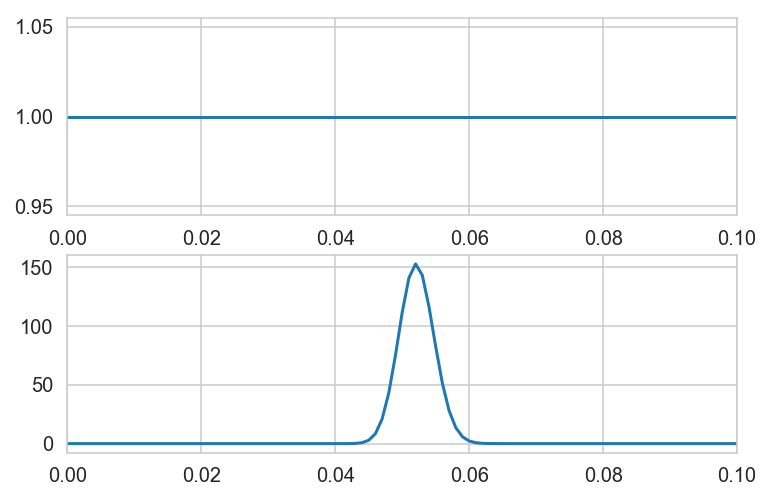

In [18]:
# Plot prior vs posterior
fig, axes = plt.subplots(nrows=2)
axes[0].plot(percentages_for_plotting_x_axes, prior_distn.pdf(percentages_for_plotting_x_axes))
axes[0].set_xlim([0, .1])

axes[1].plot(percentages_for_plotting_x_axes, posterior_distn.pdf(percentages_for_plotting_x_axes))
axes[1].set_xlim([0, .1])